LinearRegression R-squared: 0.6721, RMSE: 63969.21
DecisionTree R-squared: 0.3963, RMSE: 86799.52
RandomForest R-squared: 0.7237, RMSE: 58717.79


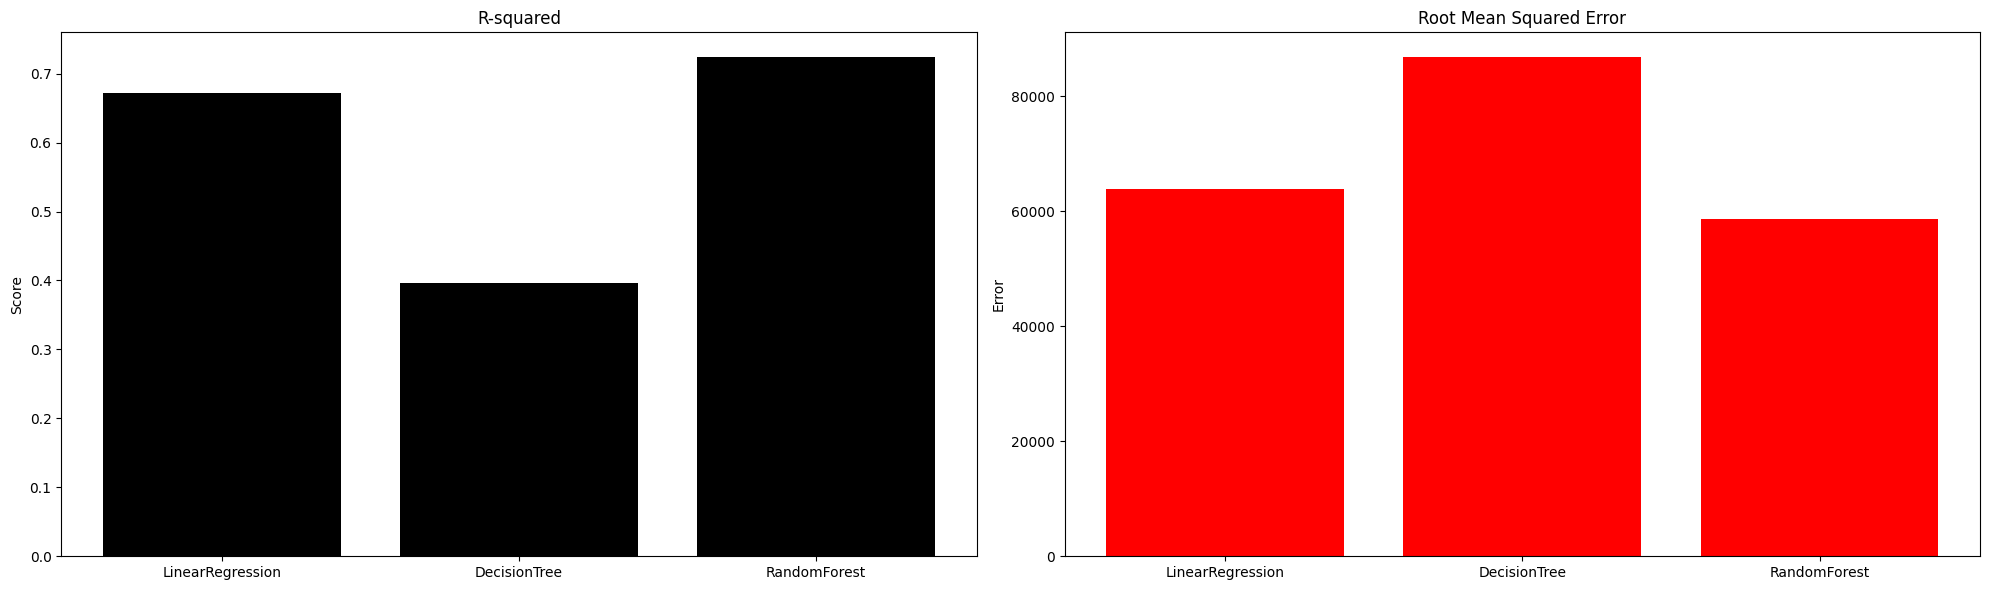

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def load_data(file_path):
    return pd.read_csv(file_path)

def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), df[column].median(), df[column])
    return df

def preprocess_data_lr(data):
    data.dropna(subset=['ocean_proximity'], inplace=True)
    numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                         'total_bedrooms', 'population', 'households', 'median_income']
    categorical_features = ['ocean_proximity']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    X = data.drop('median_house_value', axis=1)
    y = data['median_house_value']
    return X, y, preprocessor

def preprocess_data_dt_rf(data):
    data.dropna(subset=['ocean_proximity'], inplace=True)
    numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                         'total_bedrooms', 'population', 'households', 'median_income']
    categorical_features = ['ocean_proximity']
    numeric_transformer = SimpleImputer(strategy='median')
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    X = data.drop('median_house_value', axis=1)
    y = data['median_house_value']
    return X, y, preprocessor

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    # mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return r_squared, rmse

def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', model['preprocessor']),
            ('model', model['model'])
        ])
        pipeline.fit(X_train, y_train)
        r_squared, rmse = evaluate_model(pipeline, X_test, y_test)
        results[name] = {'R-squared': r_squared,'RMSE': rmse}
        print(f"{name} R-squared: {r_squared:.4f}, RMSE: {rmse:.2f}")
    return results

# Load data
data = load_data("/content/housing_coursework_entire_dataset_23-24.csv")

# Preprocess data for Linear Regression
X_lr, y_lr, preprocessor_lr = preprocess_data_lr(data)

# Preprocess data for Decision Tree and Random Forest
X_dt_rf, y_dt_rf, preprocessor_dt_rf = preprocess_data_dt_rf(data)

# Split data
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)
X_train_dt_rf, X_test_dt_rf, y_train_dt_rf, y_test_dt_rf = train_test_split(X_dt_rf, y_dt_rf, test_size=0.2, random_state=42)

# Define regression models with hyperparameter tuning
models = {
    'LinearRegression': {'model': LinearRegression(), 'preprocessor': preprocessor_lr},
    'DecisionTree': {'model': DecisionTreeRegressor(random_state=42), 'preprocessor': preprocessor_dt_rf},
    'RandomForest': {'model': RandomForestRegressor(random_state=42), 'preprocessor': preprocessor_dt_rf}
}

# Train and evaluate models
results = train_and_evaluate_models(models, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

# Plotting
models_names = list(models.keys())
r_squared_scores = [results[model]['R-squared'] for model in models_names]
# mae_scores = [results[model]['MAE'] for model in models_names]
rmse_scores = [results[model]['RMSE'] for model in models_names]

plt.figure(figsize=(20, 6))

# R-squared plot
plt.subplot(1, 2, 1)
plt.bar(models_names, r_squared_scores, color='black')
plt.title('R-squared')
plt.ylabel('Score')

# # Mean Absolute Error plot
# plt.subplot(1, 3, 2)
# plt.bar(models_names, mae_scores, color='yellow')
# plt.title('Mean Absolute Error')
# plt.ylabel('Error')

# Root Mean Squared Error plot
plt.subplot(1, 2, 2)
plt.bar(models_names, rmse_scores, color='red')
plt.title('Root Mean Squared Error')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

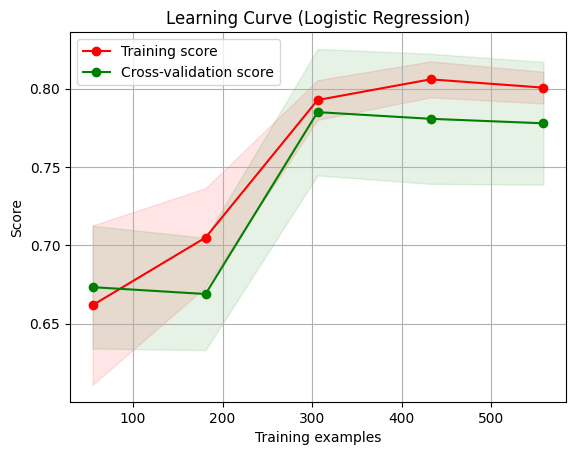

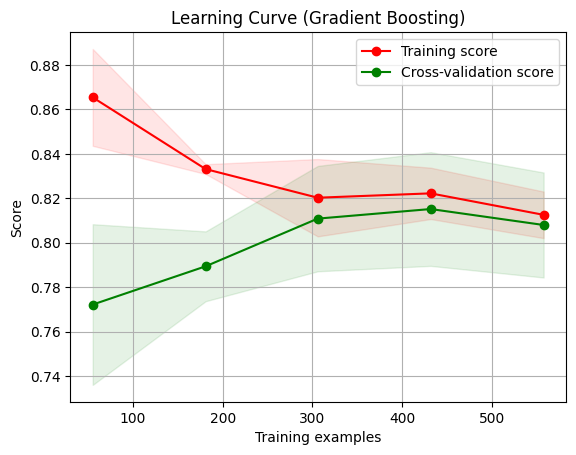

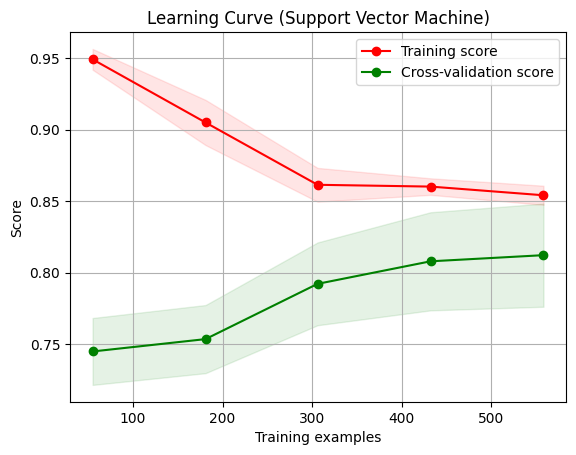

Classifier: Logistic Regression
Accuracy: 0.82
Precision: 0.84

Classifier: Gradient Boosting
Accuracy: 0.82
Precision: 0.89

Classifier: Support Vector Machine
Accuracy: 0.85
Precision: 0.85



In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def preprocess_and_train(dataset_path="/content/Titanic_coursework_entire_dataset_23-24.csv"):
    # Read the dataset
    df = pd.read_csv(dataset_path)

    # Drop unnecessary columns
    df.drop(["Name", "PassengerId", "Ticket"], axis=1, inplace=True)

    # Handling missing values for Age, Fare, and Embarked
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Fare"].fillna(df["Fare"].median(), inplace=True)
    most_common_embarked = df["Embarked"].mode()[0]
    df["Embarked"].fillna(most_common_embarked, inplace=True)

    # Convert categorical variables to numerical
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

    # Feature engineering: Create new features
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df["IsAlone"] = df["FamilySize"].apply(lambda x: 1 if x == 1 else 0)
    age_bins = [0, 18, 30, 50, 100]

    age_labels = [0, 1, 2, 3]
    df["AgeCategory"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels)
    fare_bins = [-1, 10, 50, 1000]
    fare_labels = [0, 1, 2]

    df["FareCategory"] = pd.cut(df["Fare"], bins=fare_bins, labels=fare_labels)
    df.drop(["Age", "Fare"], axis=1, inplace=True)
    df["AgeCategory"] = df["AgeCategory"].astype(int)
    df["FareCategory"] = df["FareCategory"].astype(int)
    df.dropna(inplace=True)

    # Split data into features and target
    X = df.drop("Survival", axis=1)
    y = df["Survival"]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=190, shuffle=False)

    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define classifiers
    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Support Vector Machine": SVC()
    }

    # Define hyperparameters for grid search
    param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    param_grid_gb = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7]}
    param_grid_svc = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}

    # Perform grid search cross-validation for each classifier
    tuned_classifiers = {}
    for name, clf in classifiers.items():
        if name == "Logistic Regression":
            grid_search = GridSearchCV(clf, param_grid_lr, cv=5, scoring='accuracy')
        elif name == "Gradient Boosting":
            grid_search = GridSearchCV(clf, param_grid_gb, cv=5, scoring='accuracy')
        elif name == "Support Vector Machine":
            grid_search = GridSearchCV(clf, param_grid_svc, cv=5, scoring='accuracy')

        grid_search.fit(X_train_scaled, y_train)
        tuned_classifiers[name] = grid_search.best_estimator_

    # Plot learning curves
    plot_learning_curves(tuned_classifiers, X_train_scaled, y_train)

    # Train and evaluate tuned classifiers
    results = {}
    for name, clf in tuned_classifiers.items():
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        # recall = recall_score(y_test, y_pred)
        # f1 = f1_score(y_test, y_pred)
        # roc_auc = roc_auc_score(y_test, y_pred)

        # Store the results
        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,


        }

    return results

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_learning_curves(classifiers, X_train_scaled, y_train):
    for name, clf in classifiers.items():
        plot_learning_curve(clf, f"Learning Curve ({name})", X_train_scaled, y_train, cv=5, n_jobs=-1)
        plt.show()

# Example usage:
results = preprocess_and_train("/content/Titanic_coursework_entire_dataset_23-24.csv")
for classifier, metrics in results.items():
    print(f"Classifier: {classifier}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    print()


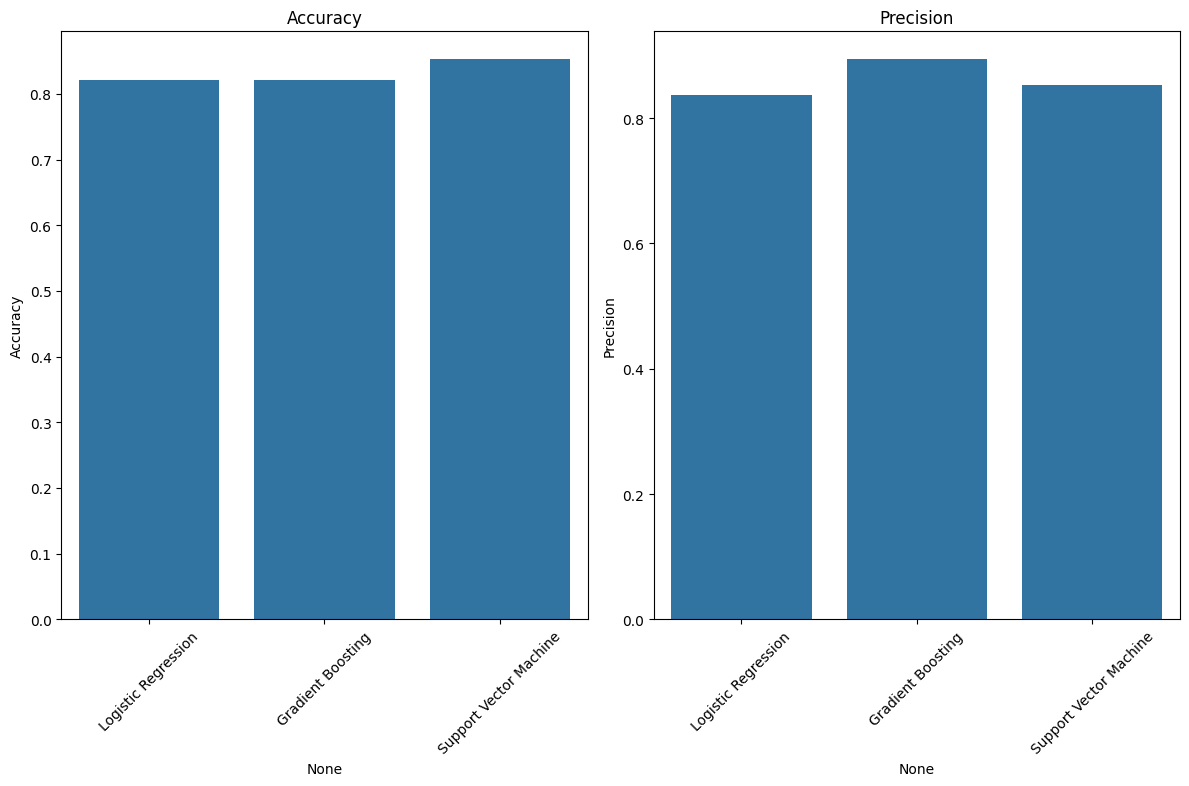

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results).T

# Plotting evaluation metrics
plt.figure(figsize=(12, 14))

# Accuracy plot
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df["Accuracy"])
plt.title("Accuracy")
plt.xticks(rotation=45)

# Precision plot
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df["Precision"])
plt.title("Precision")
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()